In [1]:
import json, glob, pycm, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from operator import itemgetter
from IPython.display import display, Markdown

In [8]:
def display_experiment(experiment):
    display(Markdown(f'## {experiment["concept"]["label"]} ({experiment["concept"]["id"]})'))
    display(Markdown(experiment["concept"]["definition"]))
    display(Markdown("### Confusion matrix"))
    cm = pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"])
    df_cm = pd.DataFrame(cm.matrix).T.fillna(0)
    ax = sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
    ax.set_title(experiment["concept"]["label"])
    ax.set(xlabel='LLM', ylabel='KG')
    plt.show()
    df = pd.DataFrame.from_records(experiment["data"])
    df_fp = df[((df["actual"] == 'negative') & (df["predicted"] == 'positive'))][["label", "description", "rationale"]]
    if len(df_fp) > 0:
        df_fp_styler = df_fp.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown("### LLM positive, KG negative"))
        display(df_fp_styler)
    df_fn = df[((df["actual"] == 'positive') & (df["predicted"] == 'negative'))][["label", "description", "rationale"]]
    if len(df_fn) > 0:
        df_fn_styler = df_fn.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown("### LLM negative, KG positive"))
        display(df_fn_styler)

In [3]:
experiments = [ json.load(open(file, 'r')) for file in glob.glob('wd_experiments_v2/*/gpt-4*') ]

In [4]:
experiment_df = pd.DataFrame.from_records([ 
    { 
        "name": experiment["concept"]['label'], 
        "kappa": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).Kappa,
        "SOA9": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).SOA9,
        "ACC": f'{pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).Overall_ACC:.1%}',
        "FP": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).FP["positive"],
        "FN": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).FN["positive"],
        "POP": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).POP["positive"],
        "experiment": experiment,
    }
    for experiment in experiments ]).sort_values("kappa", ascending=False)
experiment_df[["name", "kappa", "SOA9", "ACC", "FP", "FN", "POP"]]

,name,kappa,SOA9,ACC,FP,FN,POP
10,Cities of Japan,1.00,High,100.0%,0,0,40
14,Art movement,1.00,High,100.0%,0,0,40
5,Equestrian sport,1.00,High,100.0%,0,0,40
1,Embedded system,0.90,High,95.0%,0,2,40
17,Indigenous peoples of the Americas,0.90,High,95.0%,0,2,40
13,Fetus,0.85,High,92.5%,0,3,40
12,Village (Japan),0.85,High,92.5%,0,3,40
18,Esports,0.75,Tentative,87.5%,0,5,40
19,Natural science,0.75,Tentative,87.5%,0,5,40
16,Chronology,0.70,Tentative,85.0%,0,6,40


In [7]:
experiment_df.describe()

,kappa,FP,FN,POP
count,20.000000,20.000000,20.000000,20.0
mean,0.610000,1.150000,6.650000,40.0
std,0.331504,2.661124,6.531503,0.0
min,0.000000,0.000000,0.000000,40.0
25%,0.412500,0.000000,2.000000,40.0
50%,0.700000,0.000000,4.500000,40.0
75%,0.862500,0.000000,9.500000,40.0
max,1.000000,10.000000,20.000000,40.0


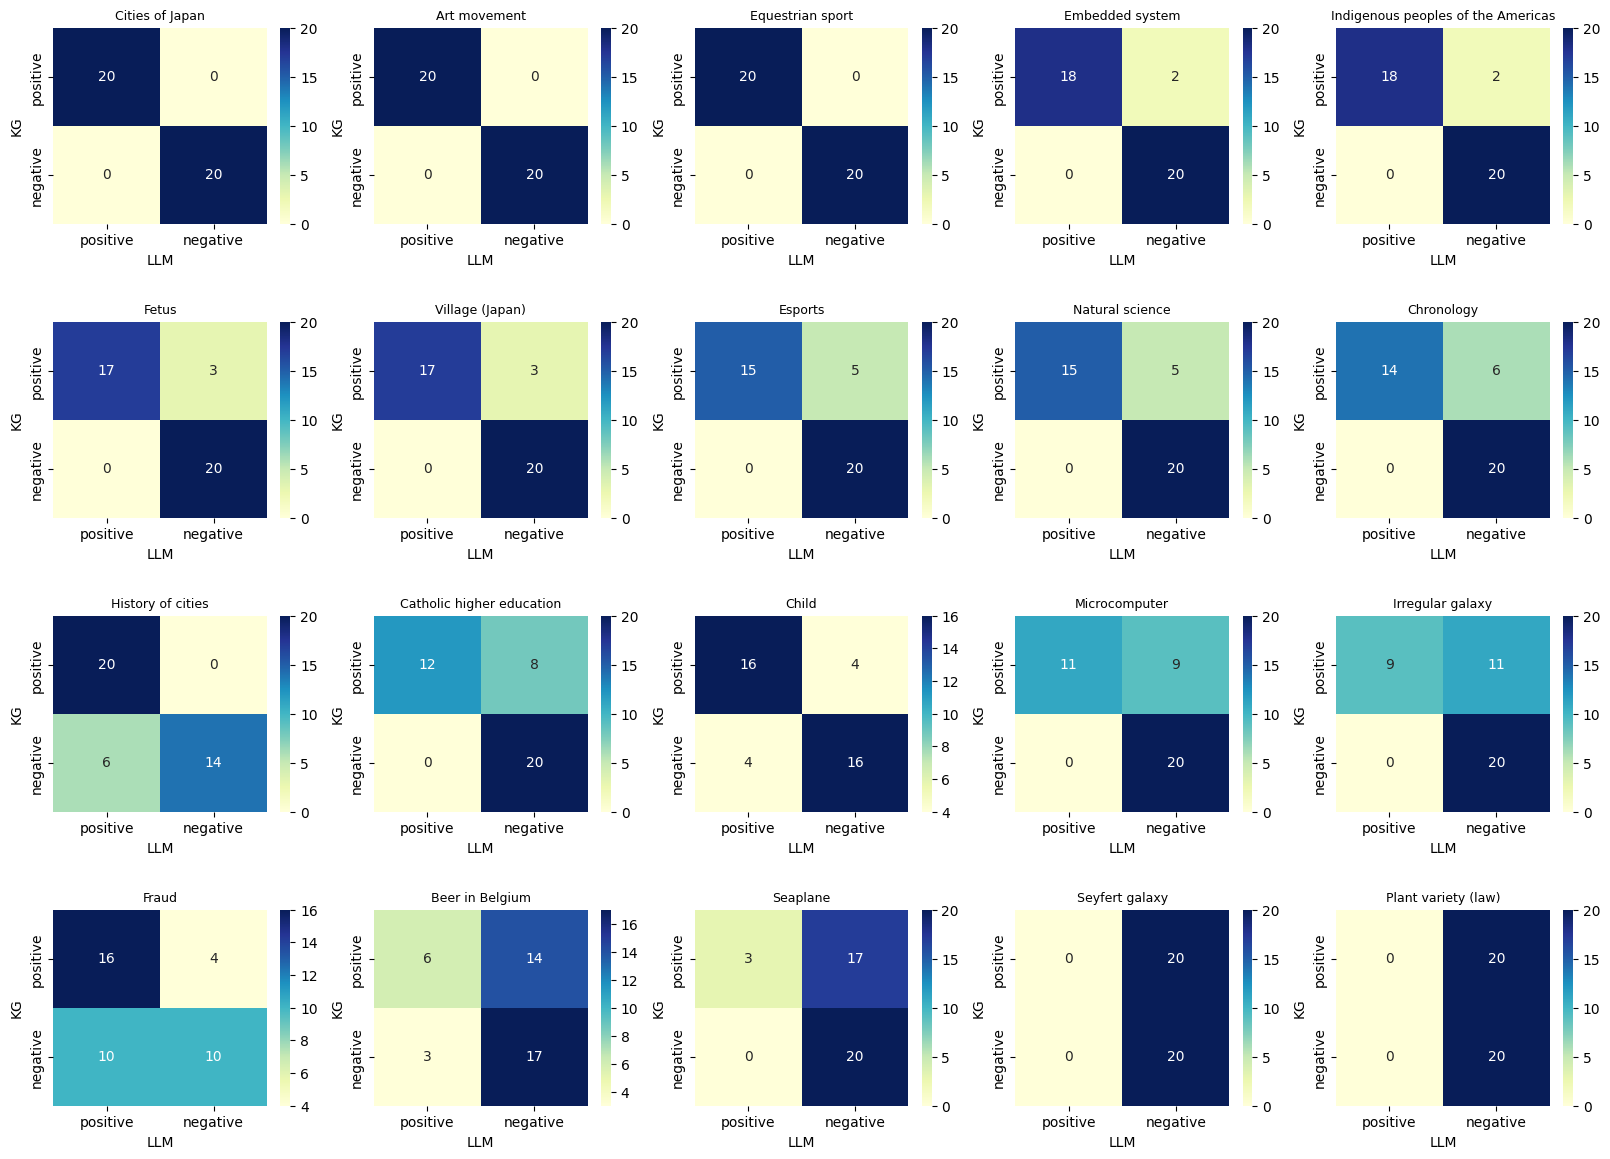

In [5]:
fig = plt.figure(figsize=(20,14))
gs = fig.add_gridspec(4, 5, hspace=0.5)
axes = gs.subplots()
cms = [ (experiment["name"], pycm.ConfusionMatrix(matrix=experiment["experiment"]["confusion_matrix"])) for experiment in experiment_df.to_dict('records')  ]
for ax, (name, cm) in zip(axes.flat, cms):
    df = pd.DataFrame(cm.matrix).T.fillna(0)
    sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", ax=ax)
    ax.set_title(name, wrap=True, fontsize=9)
    ax.set(xlabel='LLM', ylabel='KG')
for ax in axes.flat[len(cms):]:
    ax.set_visible(False)
plt.show()

## Cities of Japan (http://www.wikidata.org/entity/Q494721)

"Cities of Japan": An administrative division of Japan, also referred to as "city in Japan" or "city (Japan)".

### Confusion matrix

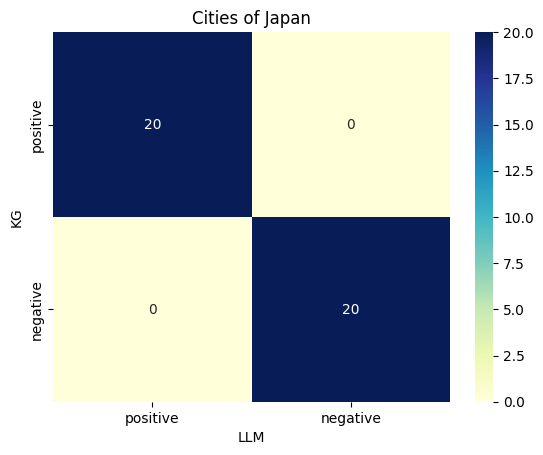

## Art movement (http://www.wikidata.org/entity/Q968159)

"Art Movement" (http://www.wikidata.org/entity/Q968159) is a term used to describe a tendency or style in art that shares a specific common philosophy or goal. It may also be associated with a specific historical period. Also known as an "artistic movement".

### Confusion matrix

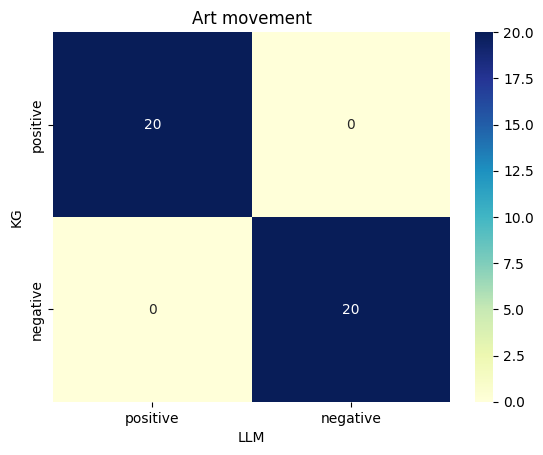

## Equestrian sport (http://www.wikidata.org/entity/Q902378)

Equestrian Sport: A segment within the field of sport that includes all activities conducted with a horse as a partner.

### Confusion matrix

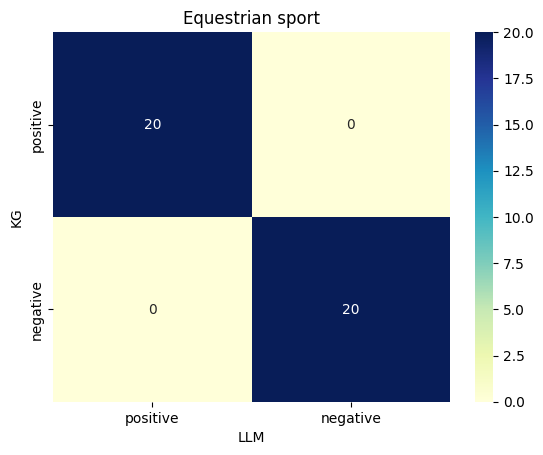

## Embedded system (http://www.wikidata.org/entity/Q193040)

An Embedded System (also known as embedded computing, embedded device, or embedded technology) is a computer system with a dedicated function within a larger mechanical or electrical system.

### Confusion matrix

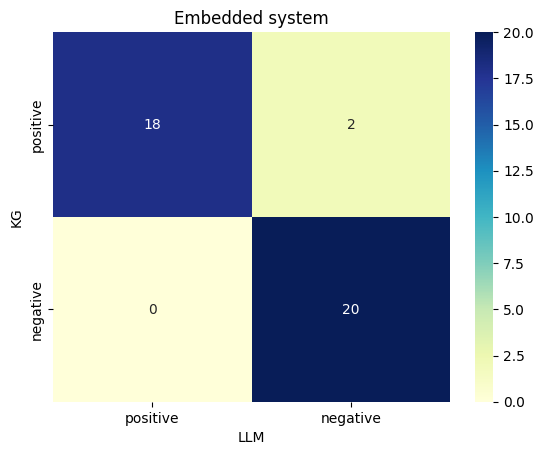

### LLM negative, KG positive

label,description,rationale
Namco Warp & Warp,"""Namco Warp & Warp"" is an entity that is primarily identified and referenced through the online database Wikidata, under the unique identifier ""Q2818458"". It is labeled in English language as ""Namco Warp & Warp"". Further information can be found on its dedicated Wikidata page.","The provided information does not give any details that would allow us to argue that Namco Warp & Warp is an Embedded System. The definition of an Embedded System requires it to be a computer system with a dedicated function within a larger mechanical or electrical system. However, there is no information given about Namco Warp & Warp that would suggest it fits this definition."
Naomi 2,"Naomi 2 is an entity, often referred to within the context of digital data or information systems. Specific details or characteristics of Naomi 2 may vary based on additional data or context provided.","The definition of an Embedded System is a computer system with a dedicated function within a larger mechanical or electrical system. While the specific details about Naomi 2 are not provided, it is referred to within the context of digital data or information systems. This suggests that Naomi 2 could be a computer system that operates within a larger system, thus potentially making it an Embedded System. However, without more specific information about Naomi 2's function and role within a larger system, it is not possible to definitively assert that Naomi 2 is an Embedded System."


## Indigenous peoples of the Americas (http://www.wikidata.org/entity/Q36747)

"Indigenous peoples of the Americas" (noun):

A collective term referring to the original inhabitants and their descendants of North, Central, and South America before the European exploration and colonization in the late 15th century. These peoples share certain cultural traits and are diverse in terms of language, culture, and societal structures. Examples include the Inca, Maya, and Aztec civilizations in Central and South America, and the Iroquois, Cherokee, and Sioux tribes in North America.

### Confusion matrix

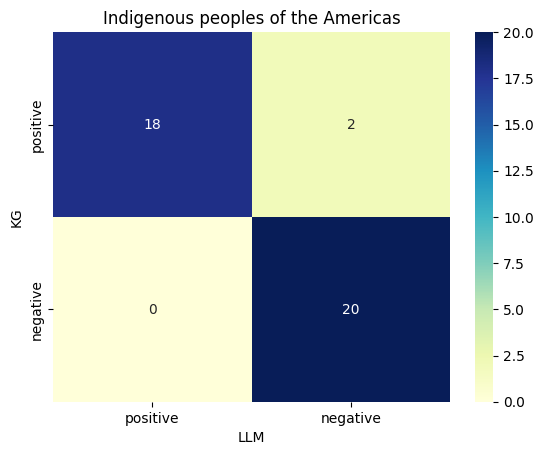

### LLM negative, KG positive

label,description,rationale
Hamatla Treaty Society,The Hamatla Treaty Society is an entity that has been recognized and identified within the Resource Description Framework (RDF).,"The provided information does not give any specific details about the Hamatla Treaty Society, such as its location, its members, or its history. Therefore, based on the given information, it is not possible to argue that the Hamatla Treaty Society is an Indigenous peoples of the Americas."
Bamoa,Bamoa is a human settlement located in Mexico.,"The definition provided does not give enough information to definitively assert that Bamoa is an Indigenous peoples of the Americas. The definition states that Indigenous peoples of the Americas refers to the original inhabitants and their descendants of North, Central, and South America before the European exploration and colonization in the late 15th century. While Bamoa is a human settlement located in Mexico, which is part of North America, there is no information provided that indicates whether the inhabitants of Bamoa are descendants of the original inhabitants before European exploration and colonization. Therefore, based solely on the provided definition, an argument cannot be made that Bamoa is an Indigenous peoples of the Americas."


## Fetus (http://www.wikidata.org/entity/Q26513)

Fetus (noun):

1. A developing, unborn mammal, from the end of the embryonic stage (after approximately eight weeks in humans) until birth.
2. The stage in prenatal development between the embryonic stage and birth. During this stage, the organism's tissues, organs, and systems continue to grow and mature. 

Note: The term "fetus" is often specifically associated with human prenatal development, but it can technically apply to other mammals as well.

### Confusion matrix

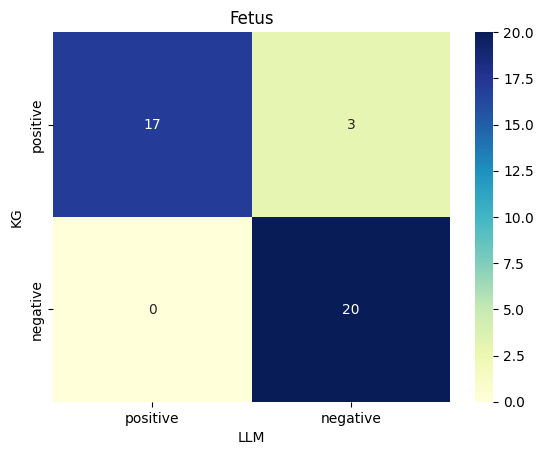

### LLM negative, KG positive

label,description,rationale
"Luísa Vitória, Princess of Grão-Pará","Luísa Vitória, Princess of Grão-Pará, also known as Louise Victoria, was a historical figure who lived in the year 1874.","Given the information provided, it is not possible to argue that Luísa Vitória, Princess of Grão-Pará is a fetus. The definition of a fetus refers to an unborn mammal in the stage of development between the embryonic stage and birth. However, Luísa Vitória, Princess of Grão-Pará is described as a historical figure who lived in the year 1874. This implies that she was born and lived a life, thus she cannot be classified as a fetus based on the provided definition."
Paul Richard Polanski,Paul Richard Polanski is the son of Sharon Tate and Roman Polanski.,"Given the information provided, it is not possible to argue that Paul Richard Polanski is a fetus. The definition of a fetus pertains to an unborn mammal in the stage of development between the embryonic stage and birth. However, the description of Paul Richard Polanski does not provide any information about him being in this stage of development. It only states that he is the son of Sharon Tate and Roman Polanski, which implies that he has already been born. Therefore, based on the provided information, Paul Richard Polanski cannot be classified as a fetus."
Basili,"Basili was possibly a stillborn child of Eudokia Baïana, who was born in 901.","Based on the provided definition, a fetus is a developing, unborn mammal from the end of the embryonic stage until birth. The description of Basili suggests that he was possibly a stillborn child. A stillborn child is one that has died in the womb or during birth. Therefore, at some point in his development, Basili would have been a fetus, as he was an unborn mammal that was developing in the womb until his birth."


## Village (Japan) (http://www.wikidata.org/entity/Q4174776)

"Village (Japan)" - Also referred to as "mura" or "son", this term represents a local administrative unit in Japan.

### Confusion matrix

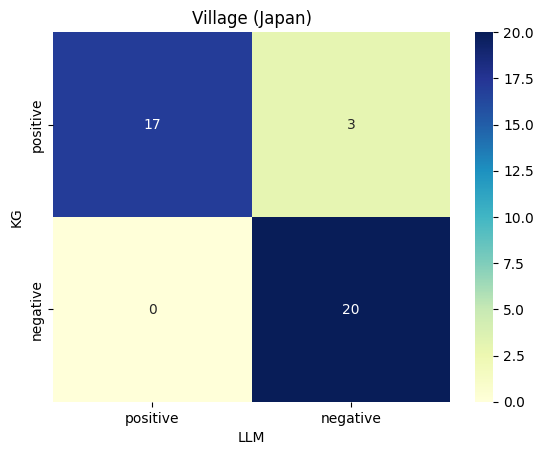

### LLM negative, KG positive

label,description,rationale
Toyota Immigrant Village,"The Toyota Immigrant Village, also known as Fengtian Immigrant Village, is an entity that is referenced and labeled in various databases and digital resources.","The Toyota Immigrant Village is referred to as an entity, which aligns with the concept of a ""local administrative unit"" as defined in the concept of a Village (Japan). Therefore, it can be argued that the Toyota Immigrant Village is a Village (Japan)."
Shibetoro,"Shibetoro is a former village located in the Kurilsky District, in the Sakhalin Oblast of Russia.","The assertion that Shibetoro is a Village (Japan) cannot be supported by the given definition and information about the entity. According to the provided details, Shibetoro is a former village located in Russia, not Japan. The definition of Village (Japan) specifies it as a local administrative unit in Japan, which does not align with the location of Shibetoro. Therefore, based on the provided information, it is not possible to argue that Shibetoro is a Village (Japan)."
Tachikawa,"Tachikawa, also known as Tatikawa, is a city located in Tokyo, Japan.","The provided definition does not support the assertion that Tachikawa is a Village (Japan). According to the definition, a Village (Japan) is a local administrative unit. However, the entity description clearly states that Tachikawa is a city located in Tokyo, Japan. Therefore, based on the provided information, Tachikawa cannot be classified as a Village (Japan)."


## Esports (http://www.wikidata.org/entity/Q300920)

"Esports" (also known as "cyber-sport", "e-sports", "electronic sports", or "pro gaming") is a form of competition that is facilitated by electronic systems, particularly video games.

### Confusion matrix

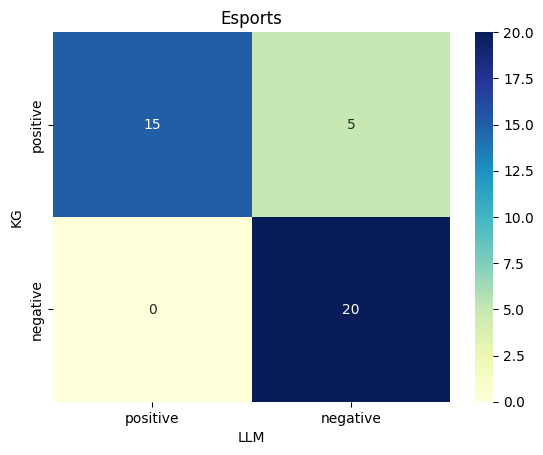

### LLM negative, KG positive

label,description,rationale
DreamHack,DreamHack is a Swedish production company.,"The definition of Esports states that it is a form of competition facilitated by electronic systems, particularly video games. While the description of DreamHack does not explicitly state that it is involved in video game competitions, it is described as a production company. Production companies are often involved in the creation, organization, and management of events or content. Therefore, it is plausible that DreamHack could be involved in the production of Esports events or content, making it a part of the Esports industry."
GIGA Television,GIGA Television is a German television station and online magazine.,"The definition provided does not offer any specific information that directly links GIGA Television to Esports. Without additional information indicating that GIGA Television facilitates electronic competition through video games, it cannot be definitively argued that GIGA Television is an Esports entity."
Treasure Master,Treasure Master is a video game that was released in 1991.,"The definition of Esports states that it is a form of competition facilitated by electronic systems, particularly video games. Treasure Master, being a video game, falls under the category of electronic systems that can facilitate competition. Therefore, based on the given definition, it can be argued that Treasure Master is an Esports."
Starcade,Starcade is an American game show television program.,"The definition of Esports is a form of competition facilitated by electronic systems, particularly video games. Starcade is a game show television program, which implies that it involves some form of competition. If this competition is facilitated by electronic systems or video games, then it could be argued that Starcade falls under the category of Esports."
2006 CPL World Season,"The 2006 CPL World Season is an entity named in English that is identified with the code Q4605896 on the Wikidata platform. This entity is associated with the RDF (Resource Description Framework) schema, a standard model for data interchange on the web.","The 2006 CPL World Season, as an entity associated with a competition, aligns with the definition of Esports which is a form of competition facilitated by electronic systems, particularly video games. Although the description does not explicitly state that the 2006 CPL World Season is a video game competition, it is reasonable to infer that it could be an Esports event given its classification as a competition. Therefore, based on the provided definition of Esports, it is plausible to assert that the 2006 CPL World Season is an Esports."


## Natural science (http://www.wikidata.org/entity/Q7991)

Definition: Natural Science (also known as Natural History or Natural Sciences) is a branch of science concerned with the natural world.

### Confusion matrix

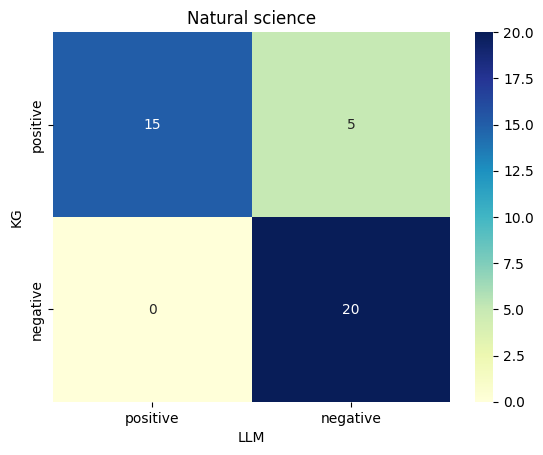

### LLM negative, KG positive

label,description,rationale
creationism,"Creationism, also known as biological creationism, is a religious belief that nature and its aspects, including the universe, Earth, life, and humans, originated from supernatural acts of divine creation.","Based on the provided definition, Natural Science is a branch of science that deals with the natural world. Creationism, as described, is a belief that nature and its aspects originated from divine creation. Given that creationism involves the study and understanding of nature and its aspects, it can be argued that it falls under the umbrella of Natural Science. This is because it involves the exploration and interpretation of natural phenomena, albeit through a religious lens."
geocentric latitude,"The geocentric latitude is a concept represented by the unique identifier ""Q149922"" in the Wikidata database. This term is in English as indicated by the '@en' tag.","Based on the provided definition, it is not possible to argue that geocentric latitude is a Natural science. The definition of Natural science refers to it as a branch of science concerned with the natural world. While geocentric latitude is a concept that may be studied within the realm of Natural science, specifically in fields like geography or astronomy, it is not a branch of science itself. Therefore, it cannot be classified as a Natural science."
diving reflex,"The diving reflex, also known as the diving response or the mammalian diving reflex, is a physiological response observed in air-breathing vertebrates when they are immersed in water.","The diving reflex is a physiological response observed in air-breathing vertebrates when they are immersed in water. This phenomenon is a part of the natural world, as it involves the biological and physical reactions of living organisms to their environment. Natural Science is a branch of science concerned with the natural world. Therefore, the study and understanding of the diving reflex, being a part of the natural world, can be considered a part of Natural Science."
Ethnic groups of Andhra Pradesh,"The ""Ethnic groups of Andhra Pradesh"" refers to the various ethnic communities residing in the Indian state of Andhra Pradesh. The diverse ethnic composition of the state includes several groups with distinct cultural, linguistic, and historical backgrounds.","Based on the provided definitions, it is not possible to argue that ""Ethnic groups of Andhra Pradesh"" is a Natural Science. Natural Science is a branch of science that deals with the natural world, focusing on understanding the physical universe. On the other hand, ""Ethnic groups of Andhra Pradesh"" refers to the various ethnic communities residing in the Indian state of Andhra Pradesh, which is a sociocultural concept rather than a natural or physical one. Therefore, the two concepts are not the same and cannot be equated."
Subsistence crisis,A subsistence crisis is a specific type of crisis that has occurred in France.,"Based on the provided definition, it is not possible to argue that a Subsistence crisis is a Natural science. Natural science is a branch of science that deals with the natural world, while a Subsistence crisis is a type of crisis, not a branch of science. Therefore, the assertion that a Subsistence crisis is a Natural science cannot be supported by the given definition."


## Chronology (http://www.wikidata.org/entity/Q130788)

Definition: Chronology is the science of arranging events in order of occurrence.

### Confusion matrix

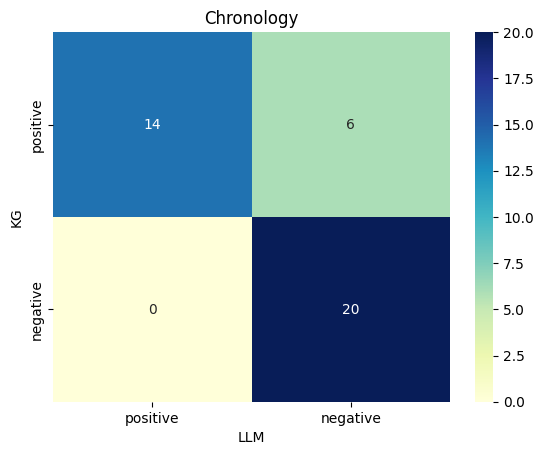

### LLM negative, KG positive

label,description,rationale
Early Dynastic Period of Egypt,"The Early Dynastic Period of Egypt, also known as the Archaic Period, is a period of ancient Egyptian history.","The Early Dynastic Period of Egypt can be considered a chronology because it represents a specific period in the history of ancient Egypt. As such, it is an event or series of events that can be arranged in order of occurrence. This aligns with the definition of chronology as the science of arranging events in their order of occurrence. Therefore, the Early Dynastic Period of Egypt can be seen as a chronology in the context of the broader history of Egypt."
MUL.APIN,"""MUL.APIN"" is a compendium that encapsulates various facets of Babylonian astronomy and astrology. This comprehensive collection provides a rich insight into the historical perspectives and practices related to celestial study and interpretation in ancient Babylon.","The MUL.APIN, as a compendium of Babylonian astronomy and astrology, likely includes records of celestial events and their interpretations. These events would have been recorded as they occurred, and thus, the MUL.APIN would be arranging these events in their order of occurrence. Therefore, based on the definition of chronology as the science of arranging events in order of occurrence, it can be argued that the MUL.APIN is a form of chronology."
Bold Beautiful Biathlon,"The ""Bold Beautiful Biathlon"" is a part of the Canadian biathlon calendar.","The assertion that Bold Beautiful Biathlon is a Chronology cannot be supported based on the given definition and information. Chronology is the science of arranging events in their order of occurrence. The Bold Beautiful Biathlon, however, is described as an event itself, not a system or method of arranging events. Therefore, it does not fit the definition of a chronology."
Dieux du Stade,"""Dieux du Stade"", also known as ""Dievx Dv Stade"", is a French nude calendar series. It predominantly features rugby players from the team Stade Français, but also includes other sportsmen.","Based on the provided definitions, it is not possible to argue that Dieux du Stade is a Chronology. Chronology is the science of arranging events in their order of occurrence. However, Dieux du Stade is described as a nude calendar series featuring sportsmen. While a calendar does involve the concept of time and order, it does not necessarily involve arranging events in their order of occurrence, which is the key aspect of a chronology. Therefore, the assertion that Dieux du Stade is a Chronology cannot be supported."
Malanka,"Malanka, also known as Melanka, Shchedra Kutia, or Shchedryi Vechir, is a folk holiday of Eastern Slavs celebrated on New Year's Eve.","Based on the provided definitions, it is not possible to argue that Malanka is a Chronology. Chronology is the science of arranging events in their order of occurrence, while Malanka is described as a folk holiday celebrated on New Year's Eve. There is no information given that suggests Malanka involves arranging events in their order of occurrence. Therefore, Malanka cannot be classified as a Chronology."
Kingfisher Calendar,The Kingfisher Calendar is a television series.,"The Kingfisher Calendar could be considered a chronology if the television series arranges events in the order of their occurrence. For instance, if each episode or season represents a specific month or year and the events within are presented in a sequential manner, it would fit the definition of a chronology. However, based on the given information, it is not explicitly stated that the Kingfisher Calendar does this, so we cannot definitively argue that it is a chronology."


## History of cities (http://www.wikidata.org/entity/Q30324006)

"History of cities" (also known as "city history" or "the city history") refers to an aspect of history that focuses on the chronological events, development, and evolution of cities over time.

### Confusion matrix

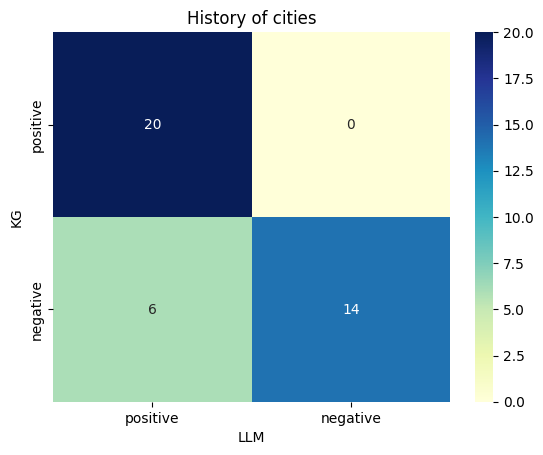

### LLM positive, KG negative

label,description,rationale
Caesaromagus,"Caesaromagus is a Roman settlement located in Beauvais, France.","Caesaromagus, as a Roman settlement located in Beauvais, France, represents a specific instance of a city. The chronological events, development, and evolution of Caesaromagus over time would fall under the study of the ""history of cities."" Therefore, the history and evolution of Caesaromagus can be considered a part of the ""history of cities."""
Nemausus,"Nemausus, also known as Augusta Nemausus and Colonia Augusta Nemausus, is an ancient Roman city that was replaced by the modern city of Nîmes.","Nemausus fits into the category of ""History of cities"" because it represents a chronological event, development, and evolution of a city over time. As the definition suggests, the ""History of cities"" focuses on the progression of cities throughout history. Nemausus, which was an ancient Roman city, has evolved and developed over time to become the modern city of Nîmes. This transformation from Nemausus to Nîmes is a clear example of the historical evolution of a city, thus making Nemausus a part of the ""History of cities""."
History of Marabá,"The ""History of Marabá"" is an entity that is also known under the alternative label ""Marabá history"".","The ""History of Marabá"" fits into the category of ""History of cities"" because it focuses on the chronological events, development, and evolution of a specific city, Marabá, over time. As such, it aligns with the definition of ""History of cities"" which is an aspect of history that focuses on the chronological events, development, and evolution of cities. Therefore, it can be argued that the ""History of Marabá"" is a ""History of cities""."
Cenabum,Cenabum is a human settlement located in France.,"Cenabum, as a human settlement located in France, has likely undergone a series of chronological events, development, and evolution over time. These processes align with the definition of ""History of cities,"" which focuses on the chronological events, development, and evolution of cities. Therefore, the history and evolution of Cenabum can be considered as a part of the ""History of cities."""
military history of Japan,"The military history of Japan, also known by its entity ID Q2236203, is a significant aspect of the nation's past that encapsulates the development, events, and key figures of its armed forces. This history spans numerous eras and provides a comprehensive understanding of Japan's strategic and tactical evolution in warfare.","The military history of Japan, as described, involves the development, events, and key figures of its armed forces. While it does not explicitly mention cities, it is reasonable to infer that the evolution of Japan's military strategies and tactics, as well as significant military events, would have had a direct impact on the development and evolution of its cities. For instance, the location of military bases, the sites of battles, or the strategic importance of certain cities could have influenced their growth, decline, or changes over time. Therefore, the military history of Japan could be considered a part of the history of its cities."
Mediolanum Santonum,"Mediolanum Santonum is a Roman town located in the historical region of Gallia Aquitania, which is present-day Saintes.","Mediolanum Santonum, being a Roman town located in the historical region of Gallia Aquitania (now known as Saintes), has a chronological history that can be traced back to the Roman era. This history includes its development and evolution over time, from a Roman town to its present-day status. Therefore, the history of Mediolanum Santonum falls under the concept of ""History of cities"" as it involves the study of its chronological events, development, and evolution."


## Catholic higher education (http://www.wikidata.org/entity/Q557206)

Catholic Higher Education: A type of university or institution of higher learning that is affiliated with the Catholic Church. Also known as a Roman Catholic university or Catholic university.

### Confusion matrix

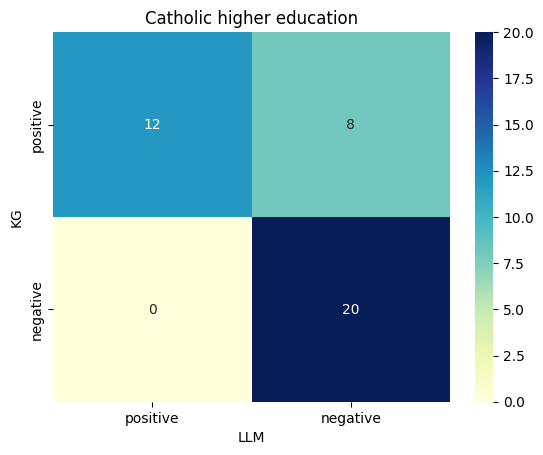

### LLM negative, KG positive

label,description,rationale
Loyola University Andalucía,"Loyola University Andalucía, also known as Universidad Loyola Andalucía and represented by the web domain ""uloyola.es"", is a higher education institution.","The definition of Catholic higher education is a type of university or institution of higher learning that is affiliated with the Catholic Church. Loyola University Andalucía is a higher education institution. Although the description does not explicitly state that Loyola University Andalucía is affiliated with the Catholic Church, the name ""Loyola"" is a strong indicator of this affiliation, as it is commonly associated with the Catholic Church and Catholic education. Therefore, it can be argued that Loyola University Andalucía is a Catholic higher education institution."
Intercultural Institute of Ayuuk,"The Intercultural Institute of Ayuuk is an educational entity that is referenced in the online database Wikidata, under the identifier Q24951967. Information about this entity is structured using the Resource Description Framework (RDF), a standard model for data interchange on the web.","The provided information does not give any evidence or argument to support the assertion that the Intercultural Institute of Ayuuk is a Catholic higher education institution. The description does not mention any affiliation with the Catholic Church or identify it as a Roman Catholic university or Catholic university. Therefore, based on the given information, it cannot be concluded that the Intercultural Institute of Ayuuk is a Catholic higher education institution."
Sogang University,"Sogang University, also known as SU, is a renowned research and liberal arts university located in Seoul, South Korea.","The definition of Catholic higher education refers to a university or institution of higher learning that is affiliated with the Catholic Church. While the description of Sogang University does not explicitly state its affiliation with the Catholic Church, it is known as a renowned research and liberal arts university. However, without explicit information about its affiliation with the Catholic Church, it is not possible to definitively argue that Sogang University is a Catholic higher education institution based solely on the provided definition and description."
Central American University (San Salvador),"The Central American University (San Salvador), also known as Universidad Centroamericana ""José Simeón Cañas"", is a private university located in El Salvador.","The definition provided for Catholic higher education refers to a university or institution of higher learning that is affiliated with the Catholic Church. While the description of the Central American University (San Salvador) does not explicitly state that it is affiliated with the Catholic Church, it is a private university. Many private universities are affiliated with religious organizations, including the Catholic Church. Therefore, it is possible that the Central American University (San Salvador) could be considered a Catholic higher education institution. However, without explicit information confirming its affiliation with the Catholic Church, this assertion cannot be definitively proven based on the provided definition and description."
University of Namur,"The University of Namur is a Belgian university also known by several alternative names. These include ""Facultes universitaires Notre-Dame de la Paix"" or ""Facultés universitaires Notre-Dame de la Paix"" in French, as well as the acronyms ""FUNDP"" and ""UNamur"". It is also referred to as ""Universite de Namur"" or ""Université de Namur"".","The definition of Catholic higher education refers to a university or institution of higher learning that is affiliated with the Catholic Church. While the description of the University of Namur does not explicitly state its affiliation with the Catholic Church, it does mention that one of its alternative names is ""Facultes universitaires Notre-Dame de la Pai

## Child (http://www.wikidata.org/entity/Q7569)

Child (noun):

1. A human being below the age of full physical development or below the legal age of majority typically considered to be 18 in many societies. 
2. A son or daughter of any age.
3. A person who is strongly influenced by or is a recipient of the legacy or influence of a preceding generation. 
4. An individual characterized by fresh, candid, or immature behavior.

### Confusion matrix

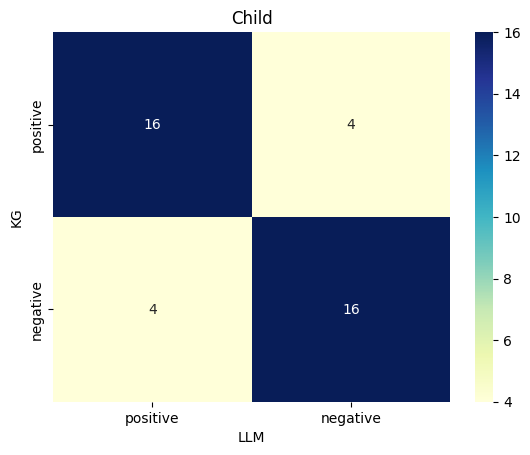

### LLM positive, KG negative

label,description,rationale
Fill Adoptiu de Palafrugell,"""Fill Adoptiu de Palafrugell"" is an English term meaning the adopted son of Palafrugell. It is a title of honor, bestowed upon an individual who, though not a biological offspring, has been accepted and embraced by the community of Palafrugell.","The term ""Fill Adoptiu de Palafrugell"" translates to the adopted son of Palafrugell. According to the second definition of a child, a child can be a son or daughter of any age. Therefore, since ""Fill Adoptiu de Palafrugell"" is referred to as a son, it can be argued that Fill Adoptiu de Palafrugell is a child. Additionally, the term ""adopted"" implies that the individual has been accepted and embraced by the community of Palafrugell, which aligns with the third definition of a child as a person who is strongly influenced by or is a recipient of the legacy or influence of a preceding generation."
Sailor Saturn,"Sailor Saturn, also known as Hotaru Tomoe, is a fictional character from the Sailor Moon series. The character is also occasionally referred to as Hotaru Tomoe (Sailor Saturn).","Sailor Saturn, also known as Hotaru Tomoe, can be considered a child based on the definition provided. Although her exact age is not specified in the description, she is a character from the Sailor Moon series, which is known for featuring young characters, often in their teenage years, which is below the age of full physical development or the legal age of majority typically considered to be 18 in many societies. Furthermore, as a character in a series, she can be seen as a recipient of the legacy or influence of a preceding generation, fitting the third definition of a child."
Basawi,Basawi is an Indian woman who is obligated to produce a male heir for her father. This cultural expectation places her in a unique social position within her community.,"Based on the provided definition, it could be argued that Basawi is a child in the sense of the third definition: ""a person who is strongly influenced by or is a recipient of the legacy or influence of a preceding generation."" The cultural expectation for Basawi to produce a male heir for her father indicates that she is under the influence of her preceding generation's traditions and norms. This cultural legacy significantly impacts her social position and life choices, making her a 'child' in this particular context."
Little Mermaid,"The Little Mermaid, also known as Princess Swanhild or simply Swanhild, is the main character in Hans Christian Andersen's story ""The Little Mermaid"".","The Little Mermaid can be considered a child based on the third definition of a child. As the main character in Hans Christian Andersen's story, she is a recipient of the legacy or influence of a preceding generation. The story itself is a part of a larger cultural and literary tradition, and the character of the Little Mermaid is shaped by the values, themes, and motifs of this tradition. Therefore, she can be seen as a 'child' of this tradition."


### LLM negative, KG positive

label,description,rationale
Marion Stone,Marion Stone is a character in English language context.,"Without specific background knowledge about Marion Stone's age, familial status, or behavior, it is impossible to definitively argue that Marion Stone is a child based on the provided definition."
Creche house Bayero University Kano state,"The Creche house Bayero University Kano state, also known as ""Crech"", is located opposite NANA HOSTEL at the old site of Bayero University in Kano state. This establishment serves as a creche house within the university's premises.","Based on the provided definition, it is not possible to argue that the Creche house Bayero University Kano state is a Child. The definition of a Child pertains to human beings, specifically those below a certain age or those who are sons or daughters. The Creche house Bayero University Kano state is an establishment or a building, not a human being. Therefore, it does not fit the definition of a Child."
Chartiste,"""Chartiste"" is an entity term in the Resource Description Framework (RDF) schema, a standard model for data interchange on the Web.","Given the information provided, it is not possible to argue that Chartiste is a Child. The definition of Child pertains to human beings, particularly in terms of age, lineage, influence, or behavior. On the other hand, Chartiste is described as an entity term in a data interchange model. There is no information suggesting that Chartiste could be considered a human being or possess any of the characteristics outlined in the definition of Child. Therefore, based on the provided definitions, Chartiste cannot be classified as a Child."
Dzieciątko,"""Dzieciątko"" is an English term associated with a Christmas custom.","The term ""Dzieciątko"" is associated with a Christmas custom. While the definition provided does not give specific details about this custom, it is possible that this custom involves a person who is below the age of full physical development or below the legal age of majority, which would make ""Dzieciątko"" a child according to the first definition. Additionally, if this custom involves a person who is strongly influenced by or is a recipient of the legacy or influence of a preceding generation, ""Dzieciątko"" could also be considered a child according to the third definition. However, without more specific information about the ""Dzieciątko"" custom, it is not possible to definitively argue that ""Dzieciątko"" is a child based solely on the provided definition."


## Microcomputer (http://www.wikidata.org/entity/Q32738)

Microcomputer: A small, relatively inexpensive computer.

### Confusion matrix

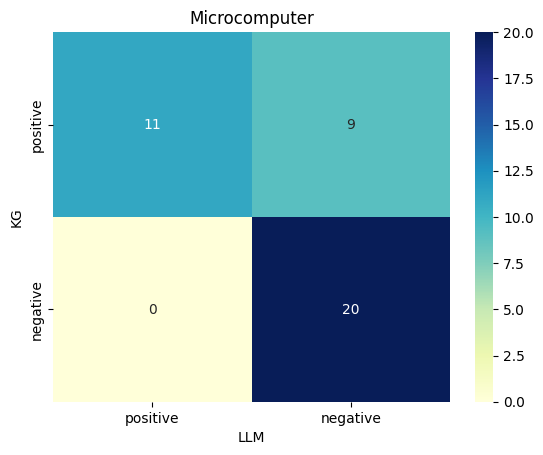

### LLM negative, KG positive

label,description,rationale
Sharp MZ-2861,The Sharp MZ-2861 is an entity that is recognized and labeled in English within the World Wide Web Consortium's (W3C) Resource Description Framework (RDF) schema. The RDF schema is a set of World Wide Web specifications used as a general method for conceptual description or modeling of information that is implemented in web resources.,"The definition of a microcomputer is a small, relatively inexpensive computer. The Sharp MZ-2861 is described as an entity within the World Wide Web Consortium's (W3C) Resource Description Framework (RDF) schema. This schema is used for conceptual description or modeling of information implemented in web resources. While the description does not directly state that the Sharp MZ-2861 is a small, relatively inexpensive computer, it is implied by its inclusion in a web-based resource framework. Therefore, it can be argued that the Sharp MZ-2861 is a microcomputer."
Sharp MZ 5500 - 5600,"The Sharp MZ 5500 - 5600 is an entity that has been referenced and cataloged in the online database, Wikidata.","The definition of a microcomputer is a small, relatively inexpensive computer. While the description of the Sharp MZ 5500 - 5600 does not explicitly state that it is a small, relatively inexpensive computer, it is implied that it is a type of computer as it has been cataloged in an online database. Therefore, it could be argued that the Sharp MZ 5500 - 5600 is a microcomputer."
Sharp MZ-80C,"The Sharp MZ-80C is an entity that is also alternatively labeled as ""Sharp MZ 80C"" and ""Sharp MZ80C"".","The definition of a microcomputer is a small, relatively inexpensive computer. The Sharp MZ-80C is identified as an entity, which implies it is a distinct thing or item. Although the description does not explicitly state that the Sharp MZ-80C is a computer, it is reasonable to infer that it could be a type of computer given its labeling and naming convention. Therefore, if the Sharp MZ-80C is indeed a small and relatively inexpensive computer, it would fit the definition of a microcomputer."
Sony HB-501,"The Sony HB-501 is an entity that is recognized and labeled in the English language within the resource description framework (RDF) schema of the online database, Wikidata.","The definition provided for a microcomputer is a small, relatively inexpensive computer. While the description of the Sony HB-501 does not explicitly state that it is a small, relatively inexpensive computer, it is recognized and labeled within the resource description framework schema of an online database, Wikidata. This suggests that the Sony HB-501 is a type of computer. Therefore, if the Sony HB-501 is indeed small and relatively inexpensive, it could be classified as a microcomputer according to the provided definition."
Dragon MSX,The Dragon MSX is a home computer prototype.,"The Dragon MSX is described as a small and relatively inexpensive computer, which aligns with the definition of a microcomputer. Therefore, it can be argued that the Dragon MSX is a microcomputer."
Sharp MZ-1500,The Sharp MZ-1500 is an entity that falls within the scope of an RDF schema label.,"The definition of a microcomputer is a small, relatively inexpensive computer. The Sharp MZ-1500 is described as an entity that falls within the scope of an RDF schema label, which implies it is a type of computer. Therefore, if the Sharp MZ-1500 is a small and relatively inexpensive computer, it fits the definition of a microcomputer."
Sharp MZ40K,"The Sharp MZ40K, also known as Sharp MZ-40K, is a subject of interest that can be found under the identification Q5959939 in Wikidata, a database that supports various knowledge applications.","The Sharp MZ40K is described as a small, relatively inexpensive computer. This aligns with the definition of a microcomputer, which is also defined as a small, relatively inexpensive computer. Therefore, it can be argued that the Sharp MZ40K is a microcomputer."
MUPID,The MUPID is a Bildschirmte

## Irregular galaxy (http://www.wikidata.org/entity/Q190397)

Irregular Galaxy: A type of galaxy that does not have a distinct regular shape, unlike a spiral or an elliptical galaxy.

### Confusion matrix

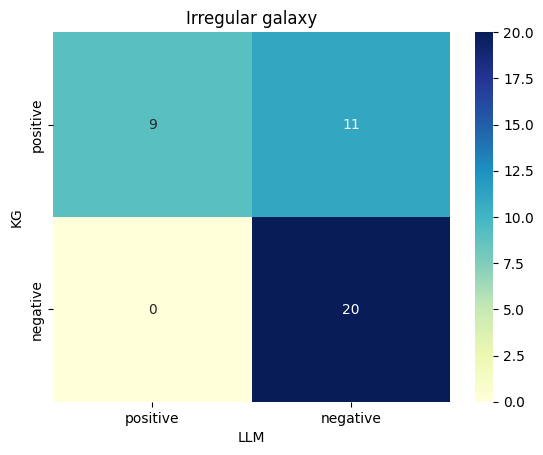

### LLM negative, KG positive

label,description,rationale
NGC 3077,"NGC 3077, also known as New General Catalogue 3077, PGC 29146, and UGC 5398, is a galaxy located in the constellation Ursa Major.","The provided definition and information do not give any specific details about the shape of NGC 3077. Therefore, based on the given information, it cannot be definitively argued that NGC 3077 is an Irregular galaxy."
NGC 1800,NGC 1800 is a galaxy that is recognized and cataloged within astronomical databases.,"The provided information does not give any specific details about the shape of NGC 1800. Therefore, based solely on the given information, it cannot be definitively argued that NGC 1800 is an Irregular galaxy."
IC 5152,IC 5152 is a galaxy that is recognized and catalogued within the astronomical community.,"The definition provided does not give specific information about IC 5152 being an Irregular galaxy. Therefore, based on the information given, it is not possible to argue that IC 5152 is an Irregular galaxy."
IC 3617,"IC 3617 is a galaxy that is cataloged in the Wikidata database, under the identifier Q3686289.","The provided information does not give any specific details about the shape or characteristics of IC 3617. Therefore, based on the given information, it cannot be definitively argued that IC 3617 is an Irregular galaxy."
IC 3518,IC 3518 is a galaxy that is identified under the designation Q3686410 in the Wikidata database.,"The provided information does not give any specific details about the shape or characteristics of IC 3518. Therefore, based solely on the given information, it cannot be definitively argued that IC 3518 is an Irregular galaxy."
MCG-02-07-026,"MCG-02-07-026, also known as A 0228-10 and PGC 9539, is a galaxy.","The provided information does not give any specific details about the shape of MCG-02-07-026. Therefore, based solely on the given definition and information, it cannot be definitively argued that MCG-02-07-026 is an Irregular galaxy."
UGC 2014,"UGC 2014, also known as A 0229+38 and PGC 9702, is a galaxy.","The provided information does not give any specific details about the shape or characteristics of UGC 2014. Therefore, based on the given information, it cannot be definitively argued that UGC 2014 is an Irregular galaxy."
UGC 2182,"UGC 2182, also known as PGC 10274, is a galaxy.","The provided information does not give any specific details about the shape of UGC 2182. Therefore, based on the given information, it cannot be definitively argued that UGC 2182 is an Irregular galaxy."
ESO 249-27,"ESO 249-27, also known as PGC 14078, is a galaxy.","The provided information does not give any specific details about the shape of ESO 249-27. Therefore, based on the given definition and information, it cannot be definitively argued that ESO 249-27 is an Irregular galaxy."
UGC 2664,"UGC 2664, also known as PGC 12400, is a galaxy.","The provided information does not give any specific details about the shape of UGC 2664. Therefore, based on the given definition and information, it cannot be definitively argued that UGC 2664 is an Irregular galaxy."


## Fraud (http://www.wikidata.org/entity/Q28813)

Fraud: An intentional deception made for unfair or unlawful gain or to damage or deprive a victim. It is also known as commercial fraud, misrepresentation (in the context of crime), or deceit.

### Confusion matrix

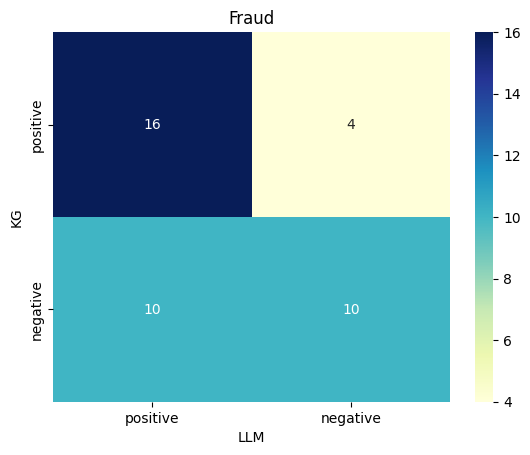

### LLM positive, KG negative

label,description,rationale
King Crowley,"King Crowley, referenced under the identifier Q114141357, is an entity categorized as an archaeological forgery.","King Crowley is categorized as an archaeological forgery. A forgery is an act of creating or altering something with the intent to deceive. This aligns with the definition of fraud, which is an intentional deception made for unfair or unlawful gain or to damage or deprive a victim. Therefore, based on the provided definition, King Crowley can be considered a fraud."
Action Replay,Action Replay is a brand of video game cheating devices.,"Action Replay could be considered a form of fraud as it involves intentional deception. The device is used to cheat in video games, which can be seen as an unfair gain. This unfair advantage could potentially damage or deprive other players who are playing the game fairly. Therefore, based on the definition of fraud, Action Replay could be seen as a fraudulent device."
GameShark,GameShark is a brand of video game cheating devices.,"GameShark could be considered a fraud based on the definition provided, as it is a device intentionally designed to deceive or misrepresent the original rules and mechanics of a video game. This deception is made for the unfair gain of the user, allowing them to bypass challenges or obstacles that are part of the game's intended experience. This could be seen as depriving the game developers of their intended design and other players of a fair competitive environment."
Code Breaker,"""Code Breaker"" is an English-language term that refers to a brand name of a cheating device.","The Code Breaker, as a cheating device, is designed to intentionally deceive a system or game for the user's unfair gain. This aligns with the definition of fraud as it involves intentional deception made for unfair gain. Therefore, one could argue that the Code Breaker is a form of fraud."
Lance Armstrong doping case,"The Lance Armstrong doping case refers to a major scandal in professional cycling. It centers around allegations and subsequent confirmations of performance-enhancing drug use by Lance Armstrong, a prominent figure in the sport.","The Lance Armstrong doping case can be considered a fraud based on the provided definition. Armstrong intentionally deceived the professional cycling community, his fans, and the public at large by using performance-enhancing drugs to gain an unfair advantage in competitions. This deceit was not only for his personal gain in terms of victories and accolades, but it also damaged the integrity of the sport and deprived other athletes of their rightful victories. Therefore, his actions align with the definition of fraud as an intentional deception made for unfair gain and to damage or deprive a victim."
Hanxin,"Hanxin is an entity that is associated with the concept of a hoax, according to the data available from Wikidata.","Given the definition of fraud as an intentional deception made for unfair or unlawful gain or to damage or deprive a victim, and the description of Hanxin as an entity associated with the concept of a hoax, it can be argued that Hanxin is a fraud. A hoax, by definition, is a deliberate deception designed to create false beliefs or impressions. This aligns with the definition of fraud, as both involve intentional deception. Therefore, if Hanxin is associated with a hoax, it can be inferred that Hanxin is involved in deceptive practices, which is a characteristic of fraud."
Japanese paleolithic hoax,"The Japanese Paleolithic hoax refers to a scandal that occurred within the field of Japanese archaeology. It was a fraudulent scheme involving the fabrication and planting of artifacts alleged to be from the Paleolithic era. The hoax was eventually exposed, leading to significant implications for the understanding and study of prehistoric Japan.","The Japanese Paleolithic hoax fits the definition of fraud as it involves intentional deception. The artifacts were fabricated and planted, w

### LLM negative, KG positive

label,description,rationale
Silver Thursday,Silver Thursday is an event that resulted in a significant drop in silver prices.,"Based on the provided definition and description, there is insufficient information to argue that Silver Thursday is a Fraud. The description does not provide any evidence of intentional deception made for unfair or unlawful gain or to damage or deprive a victim. It only mentions a significant drop in silver prices, which could be due to a variety of factors, not necessarily fraud."
How To Make Money Blogger,"""How To Make Money Blogger"" is an entity identified by Q1886291 on Wikidata. It is alternatively referred to as ""Make Money Fast"" and ""MAKE.MONEY.FAST"", and also associated with the term ""Repeat three"". This entity is described as an ""electronic chain letter"", indicating that it might involve instructions or strategies for quickly earning money through blogging, possibly involving repetition of certain steps.","The entity ""How To Make Money Blogger"" could potentially be considered a fraud based on the definition provided. This is because it is described as an ""electronic chain letter"", which often involves deceptive practices to trick people into participating, with the promise of quick financial gain. The term ""Repeat three"" associated with it could imply that participants are encouraged to repeat certain steps, possibly misleading them into believing that they can easily earn money through blogging. If these instructions or strategies are intentionally deceptive and designed to unfairly gain from participants or to cause them harm, then ""How To Make Money Blogger"" could be classified as a fraud."
Lyoness,"Lyoness, also known as Cashback World, Lyconet, and myWorld, is a multi-level marketing company.","The description of Lyoness as a multi-level marketing company could potentially suggest that it may be involved in fraudulent activities. Multi-level marketing companies often have structures that resemble pyramid schemes, which are inherently fraudulent as they rely on the recruitment of more and more members to sustain the profits of those at the top of the pyramid. If Lyoness operates in such a way, it could be intentionally deceiving its members for unfair gain, thus fitting the definition of fraud. However, without more specific information about Lyoness's operations, it is not possible to definitively assert that it is a fraud."
Tanaka Memorial,"The Tanaka Memorial is an alleged Japanese strategic planning document from 1927. It is attributed to Prime Minister Baron Tanaka Giichi, who is said to have outlined a strategy for global domination to Emperor Hirohito.","The Tanaka Memorial could be considered a fraud if it was intentionally created as a deception for unfair or unlawful gain, or to damage or deprive a victim. If the document was not actually written by Prime Minister Baron Tanaka Giichi, or if it did not truly outline a strategy for global domination to Emperor Hirohito, then it would be a misrepresentation or deceit. This would be especially true if the document was used to manipulate public opinion, policy decisions, or other important matters. Therefore, based on the provided definition, there is a potential argument for the Tanaka Memorial being a fraud."


## Beer in Belgium (http://www.wikidata.org/entity/Q348229)

Beer in Belgium (http://www.wikidata.org/entity/Q348229): A product of fermentation characterized by its origin from Belgium. Often known as Belgian beer, it represents a broad collection of ales, lagers, and other beer types produced within the country.

### Confusion matrix

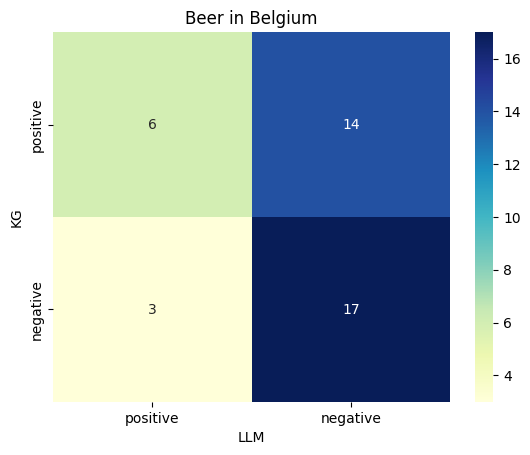

### LLM positive, KG negative

label,description,rationale
Anker Pils,Anker Pils is a Belgian beer.,"The definition of Beer in Belgium includes any beer types produced within the country of Belgium. Anker Pils is explicitly stated to be a Belgian beer, which means it is produced within Belgium. Therefore, based on the provided definition, Anker Pils can be classified as a Beer in Belgium."
Maes pils,Maes Pils is a Belgian beer that is brewed by Alken-Maes.,"The definition of Beer in Belgium includes any beer types produced within the country of Belgium. Maes Pils is explicitly stated to be a Belgian beer, brewed by Alken-Maes. Therefore, based on the provided definition, Maes Pils can be classified as a Beer in Belgium."
Cristal,"Cristal, also known as Cristal Alken, is a type of pilsner.","Cristal is a type of pilsner, which is a type of beer. The description of Cristal also includes the name ""Cristal Alken,"" which suggests a connection to Belgium (as Alken is a municipality in Belgium). Therefore, based on the definition of Beer in Belgium as a broad collection of ales, lagers, and other beer types produced within the country, it can be argued that Cristal is a Beer in Belgium."


### LLM negative, KG positive

label,description,rationale
Abbaye de Cambron,"The ""Abbaye de Cambron"" is an entity referenced in the Wikidata database.","The provided definition does not supply enough information to assert that Abbaye de Cambron is a Beer in Belgium. There is no information given about Abbaye de Cambron's relation to beer production or its location in Belgium. Therefore, based on the given definition and information, it is not possible to provide a rationale for this assertion."
Blanche de Namur,"Blanche de Namur is an entity referenced in the Wikidata database, denoted by the unique identifier Q519781.","Given that Blanche de Namur is an entity referenced in the Wikidata database, it can be inferred that it is a product or concept of some kind. The definition of Beer in Belgium includes a broad collection of ales, lagers, and other beer types produced within the country. Although the specific type of Blanche de Namur is not mentioned, it is reasonable to infer that it could be a type of beer produced in Belgium. Therefore, based on the provided definition, it can be argued that Blanche de Namur is a Beer in Belgium."
Achel Brewery,Achel Brewery is an entity referenced in the digital world through the unique resource identifier http://www.wikidata.org/entity/Q610086. This label is denoted in English language as per the semantics of Resource Description Framework (RDF).,"The definition of Beer in Belgium includes any beer types produced within the country of Belgium. While the description of Achel Brewery does not explicitly state that it produces beer, the term ""Brewery"" in its name strongly suggests that it is involved in the production of beer. Furthermore, the entity is referenced in the digital world with a unique identifier, indicating its existence and relevance. Therefore, it can be argued that Achel Brewery, being a brewery presumably located in Belgium, is a producer of Beer in Belgium."
Dominus,"Dominus is a term that is described as a ""beer"" according to the provided RDF statements.","Given that Dominus is described as a ""beer"" according to the provided RDF statements, it can be inferred that it is a product of fermentation. The definition of Beer in Belgium includes any beer type produced within the country. Although the origin of Dominus is not explicitly stated, if we assume that it is produced in Belgium, it would fall under the category of Beer in Belgium. Therefore, based on the provided definition, it is plausible to assert that Dominus is a Beer in Belgium."
Saison de Pipaix,"""Saison de Pipaix"" is an entity referenced in the Wikidata database under the identifier Q2535987.","The definition of Beer in Belgium includes a broad collection of ales, lagers, and other beer types produced within the country. Given that ""Saison de Pipaix"" is an entity referenced in the Wikidata database, it can be inferred that it is a product or item of some sort. While the definition does not explicitly state that ""Saison de Pipaix"" is a beer, it is reasonable to argue that it could be a type of beer produced in Belgium, thus making it a Beer in Belgium."
3 Fonteinen Oude Kriek,"""3 Fonteinen Oude Kriek"" is a notable entity in the realm of beverages.","The definition of Beer in Belgium includes any beer types produced within the country. Given that ""3 Fonteinen Oude Kriek"" is a beverage, it can be inferred that it is a type of beer. If ""3 Fonteinen Oude Kriek"" is produced in Belgium, it would fall under the category of Beer in Belgium as per the provided definition."
Crabbelaer,Crabbelaer is an entity that is indexed under the identifier Q15985396 in the Wikidata database.,"Given that Crabbelaer is an entity indexed in the Wikidata database, it is reasonable to infer that it is a product or concept of some significance. The definition of Beer in Belgium includes a broad collection of ales, lagers, and other beer types produced within the country. While the description of Crabbelaer does not explicitly state that it is a beer,

## Seaplane (http://www.wikidata.org/entity/Q115940)

Seaplane (noun): A class of airplane also known as a hydroplane, hydroaeroplane, or water-based aircraft, characterized by its ability to take off and land on water.

### Confusion matrix

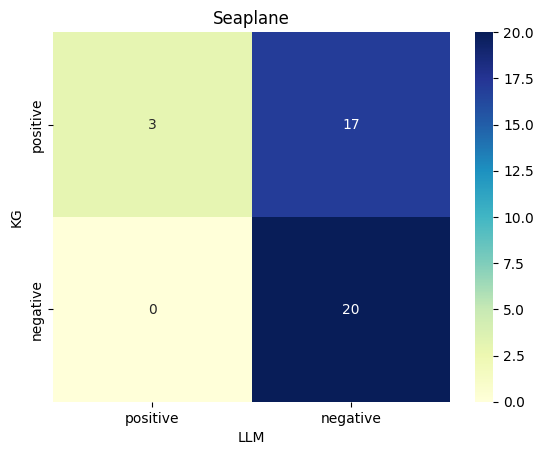

### LLM negative, KG positive

label,description,rationale
A-851,"A-851, also known as BuNo A-851, is an entity associated with the United States Navy. It is specifically identified as H-16 within the organization.","The provided information does not give any specific details that would allow us to categorize A-851 as a Seaplane. The definition of a Seaplane is an aircraft that can take off and land on water, but there is no information given that suggests A-851 has this capability. Therefore, based on the information given, we cannot assert that A-851 is a Seaplane."
A-852,"A-852, also known as BuNo A-852, is identified as the H-16 of the United States Navy.","The definition provided does not offer any information that would allow us to categorize A-852 as a seaplane. The description of A-852 does not mention any characteristics that align with the definition of a seaplane, such as the ability to take off and land on water. Therefore, based solely on the given definition and the information about A-852, we cannot argue that A-852 is a seaplane."
A-858,"A-858, also known as BuNo A-858, is an entity identified as the H-16 of the United States Navy.","The definition of a seaplane is an airplane that can take off and land on water. While the description of A-858 does not explicitly state that it can take off and land on water, it is identified as the H-16 of the United States Navy. Given that the Navy operates on water, it can be inferred that A-858, being a part of the Navy's fleet, has the ability to take off and land on water. Therefore, based on the provided definition, A-858 can be classified as a seaplane."
A-1046,"A-1046, also known as BuNo A-1046, is recognized as H-16 of the United States Navy.","The provided information does not give any evidence or details that would allow us to argue that A-1046 is a Seaplane. The definition of a Seaplane is an aircraft that can take off and land on water, but there is no information given about A-1046's capabilities in this regard. Therefore, based on the information provided, we cannot assert that A-1046 is a Seaplane."
A-1043,"A-1043, also known as BuNo A-1043, is an entity associated with the United States Navy, specifically known as H-16.","The provided definition and information do not provide sufficient evidence to argue that A-1043 is a Seaplane. The definition of a Seaplane is an aircraft that can take off and land on water, but there is no information given about A-1043's ability to do so. Therefore, based solely on the provided information, we cannot assert that A-1043 is a Seaplane."
A-1037,"A-1037, also known as BuNo A-1037, is a designation related to the United States Navy. It is specifically associated with the H-16 sector of the Navy.","The provided information does not give any evidence or context to suggest that A-1037 is a seaplane. The definition of a seaplane is clear, but the description of A-1037 does not mention any characteristics that would classify it as a seaplane. Therefore, based on the given information, it is not possible to argue that A-1037 is a seaplane."
Catalina PBY-5-03,The Catalina PBY-5-03 is a Brazilian military airplane that crashed in 1947.,"The definition of a seaplane is a class of airplane that has the ability to take off and land on water. While the description of the Catalina PBY-5-03 does not explicitly state that it can take off and land on water, it is implied by the terms ""hydroplane,"" ""hydroaeroplane,"" and ""water-based aircraft"" used in the definition of a seaplane. Therefore, it can be inferred that the Catalina PBY-5-03 is a seaplane."
Pacific Clipper,"The Pacific Clipper, also known as the California Clipper and identified as NC18609(A), is a significant entity in aviation history. It is recognized for being the first commercial plane to circumnavigate the world.","The Pacific Clipper is a seaplane because it is an airplane that has the ability to take off and land on water. This characteristic aligns with the definition of a seaplane, which is defined 

## Seyfert galaxy (http://www.wikidata.org/entity/Q213930)

Seyfert Galaxy: A class of galaxies characterized by the specific properties defined under the entity Q213930.

### Confusion matrix

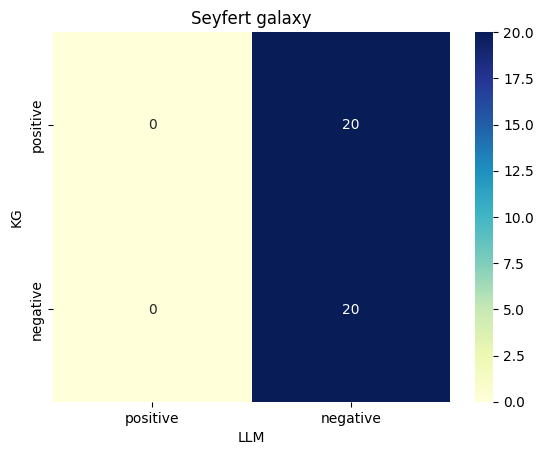

### LLM negative, KG positive

label,description,rationale
NGC 1672,"NGC 1672, also known as PGC 15941, is a barred spiral galaxy located in the constellation Dorado.","The provided definition and description do not provide sufficient information to argue that NGC 1672 is a Seyfert galaxy. The definition of a Seyfert galaxy refers to specific properties defined under the entity Q213930, but these properties are not specified in the provided information. Furthermore, the description of NGC 1672 does not mention any characteristics that could be associated with Seyfert galaxies. Therefore, based on the given information, it is not possible to provide an argument for the assertion that NGC 1672 is a Seyfert galaxy."
Messier 77,"Messier 77, also known as M77, is a spiral galaxy located in the constellation Cetus. It is alternatively referred to as PGC 10266, UGC 2188, Cetus A, New General Catalogue 1068, and NGC 1068.","The provided definition does not give specific properties that characterize a Seyfert galaxy, therefore, based on the given information, it is not possible to argue that Messier 77 is a Seyfert galaxy."
7C 114610.00+594129.00,"7C 114610.00+594129.00, also known as Q733508 in the Wikidata repository, is a blazar. A blazar is a type of active galactic nucleus with a jet, or an energetic stream of particles, that the observer views directly. The object's particular characteristics and behaviors are described further in the Wikidata resource.","The provided definition and information do not provide sufficient evidence to argue that 7C 114610.00+594129.00 is a Seyfert galaxy. The definition of a Seyfert galaxy is not explicitly provided, and the entity 7C 114610.00+594129.00 is described as a blazar, not a Seyfert galaxy. Without additional information linking these two concepts, an argument cannot be made based solely on the provided definition and description."
NGC 5322,NGC 5322 is a galaxy.,"The provided definition does not give any specific properties or characteristics of a Seyfert galaxy, nor does it provide any information linking NGC 5322 to the properties of a Seyfert galaxy. Therefore, based solely on the given information, it is not possible to provide an argument for the assertion that NGC 5322 is a Seyfert galaxy."
NGC 3259,"NGC 3259, also known as 1RXS J103233.8+650235, is a spiral galaxy.","The provided definition and description do not provide enough information to argue that NGC 3259 is a Seyfert galaxy. The definition refers to specific properties defined under the entity Q213930, but these properties are not specified in the provided information. Furthermore, the description of NGC 3259 does not mention any characteristics that could be associated with Seyfert galaxies. Therefore, based on the given information, it is not possible to argue that NGC 3259 is a Seyfert galaxy."
NGC 5033,NGC 5033 is a spiral galaxy located in the constellation Canes Venatici.,"The provided definition does not give any specific properties or characteristics of a Seyfert galaxy, nor does it provide any information linking NGC 5033 to being a Seyfert galaxy. Therefore, based solely on the given definition, it is not possible to provide an argument for the assertion that NGC 5033 is a Seyfert galaxy."
NGC 6394,"NGC 6394, also known as SBb, is a barred spiral galaxy.","The provided definition does not give specific properties that characterize a Seyfert galaxy, therefore, based on the given information, it is impossible to argue that NGC 6394 is a Seyfert galaxy."
NGC 617,"NGC 617 is a galaxy, identified and named as per the data available on Wikidata. The term ""NGC 617"" serves as the designated label for this specific celestial entity.","The provided definition and information do not contain any specific details or characteristics about NGC 617 that would allow us to categorize it as a Seyfert galaxy. Therefore, based solely on the given information, we cannot argue that NGC 617 is a Seyfert galaxy."
NGC 1019,"NGC 1019 is a galaxy. This celestial body is

## Plant variety (law) (http://www.wikidata.org/entity/Q1363241)

"Plant variety (law)" - A term referring to the legal status of a cultivated plant that may not be propagated. This concept is associated with the entity Q1363241 in the Wikidata database.

### Confusion matrix

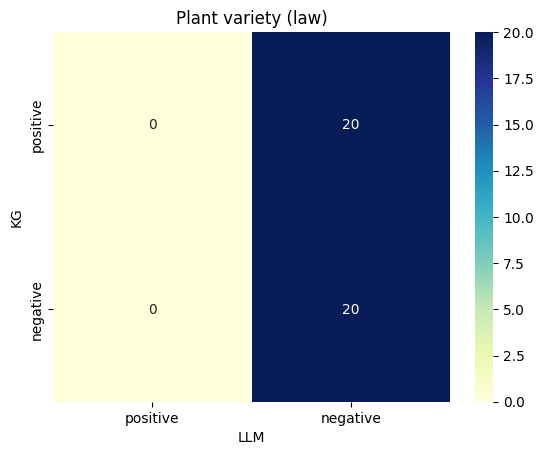

### LLM negative, KG positive

label,description,rationale
Cleopatra,"Cleopatra is a plum cultivar, also known as Cherry plum 'Cleopatra'.","The definition of ""Plant variety (law)"" refers to a cultivated plant that may not be propagated. The entity Cleopatra is described as a plum cultivar, which means it is a cultivated plant. Therefore, based on the provided definition, Cleopatra could be considered a ""Plant variety (law)"" if it is not allowed to be propagated."
Hawkeye (ciruela),Hawkeye (ciruela) is a variety of plum cultivar.,"The definition of ""Plant variety (law)"" refers to a cultivated plant that may not be propagated. The entity Hawkeye (ciruela) is described as a variety of plum cultivar, which implies that it is a cultivated plant. Therefore, based on the given definition, it can be argued that Hawkeye (ciruela) falls under the category of ""Plant variety (law)""."
African Rose,"The African Rose is a variety of plum that was developed through the program of ""ARC - lnfruitec"", a public initiative in South Africa.","The African Rose, as a variety of plum, falls under the category of cultivated plants. It was developed through a specific program, indicating that it is not a naturally occurring variety but rather one that has been intentionally propagated. According to the definition of ""Plant variety (law)"", this would suggest that the African Rose may have a legal status that prevents its propagation, thus making it a ""Plant variety (law)""."
Prunus salicina 'Alhambra',Prunus salicina 'Alhambra' is a plum cultivar. The specific entity is referenced in the Wikidata database under the identifier Q114796259.,"Given the definition of ""Plant variety (law)"" as a legal status of a cultivated plant that may not be propagated, and the description of Prunus salicina 'Alhambra' as a plum cultivar, it can be inferred that Prunus salicina 'Alhambra' could potentially be a ""Plant variety (law)"". This is because a cultivar is a plant variety that has been produced in cultivation by selective breeding. If Prunus salicina 'Alhambra' is a cultivar that is legally not allowed to be propagated, then it would fit the definition of a ""Plant variety (law)"". However, without specific information stating that propagation of Prunus salicina 'Alhambra' is legally prohibited, it cannot be definitively stated that it is a ""Plant variety (law)""."
Heron,"Heron, identified by the resource identifier http://www.wikidata.org/entity/Q117878607, is a term in English language. It is also referred to as ""Prunus domestica"".","The entity Heron is identified as ""Prunus domestica"", which is a type of cultivated plant. According to the definition of ""Plant variety (law)"", this term refers to the legal status of a cultivated plant that may not be propagated. Therefore, if Heron (Prunus domestica) is a cultivated plant and it is legally not allowed to be propagated, it could be considered a ""Plant variety (law)""."
Comox,Comox is a variety of raspberry.,"According to the provided definition, a ""Plant variety (law)"" refers to a cultivated plant that may not be propagated. Given that Comox is described as a variety of raspberry, it can be inferred that it is a cultivated plant. However, the definition does not provide information on whether Comox may or may not be propagated. Therefore, based solely on the provided definition, it cannot be definitively argued that Comox is a ""Plant variety (law)"". More information would be needed on the propagation status of Comox to make this determination."
Prunus domestica ʽJojo’,Prunus domestica 'Jojo' is an English-language term referring to a specific cultivar of plum.,"The definition of ""Plant variety (law)"" refers to a cultivated plant that may not be propagated. The entity Prunus domestica 'Jojo' is described as a specific cultivar of plum. A cultivar is a plant variety that has been produced in cultivation by selective breeding. Therefore, it can be argued that Prunus domestica 'Jojo' fits the definition of a ""Plant var

In [9]:
for experiment in experiment_df["experiment"].values:
    display_experiment(experiment)